In [1]:
!pip install split_folders

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import splitfolders


from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential

from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import itertools


from tensorflow.keras.applications import VGG19, Xception, InceptionV3, ResNet50, EfficientNetB4, NASNetMobile 


import warnings
warnings.filterwarnings("ignore")


2024-06-16 10:31:33.130132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 10:31:33.130245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 10:31:33.233995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
loc = "/kaggle/input/asd-eye-data/ASDeyedata"

In [4]:
# Create output directories
os.makedirs('output', exist_ok = True)
os.makedirs('output/train', exist_ok = True)
os.makedirs('output/val', exist_ok = True)
os.makedirs('output/test', exist_ok = True)

In [5]:
splitfolders.ratio(loc, output = 'output', seed = 0, ratio = (0.8,0.1,0.1))

Copying files: 547 files [00:02, 193.70 files/s]


In [6]:
# Load data
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

In [7]:
# load training data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    image_size = (224,224),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = True,
    seed = 0)


# load testing data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    image_size = (224,224),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False)


# load validation data
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, 
    image_size = (224,224),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False)



Found 437 files belonging to 2 classes.
Found 57 files belonging to 2 classes.
Found 53 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names
class_count = len(class_names)
print("Number of classes : ",class_count)
print(class_names)

Number of classes :  2
['TCImages-0', 'TSImages-1']


In [9]:
def create_model(model_name):
    
    input_shape = (224,224,3)
    base_model = None
    
    
    if model_name == "VGG19":
        base_model = VGG19(include_top = False, 
                           weights = "imagenet", 
                           input_shape = input_shape, 
                           pooling = "max")  
    
    elif model_name == "Xception":
        base_model = Xception(include_top = False, 
                              weights = "imagenet", 
                              input_shape = input_shape, 
                              pooling = "max")
    
    elif model_name == 'EfficientNetB4':
        base_model = EfficientNetB4(include_top=False, 
                                    weights="imagenet", 
                                    input_shape=input_shape, 
                                    pooling='max')
    
    elif model_name == 'NASNetMobile':
        base_model = NASNetMobile(include_top=False, 
                                  weights="imagenet", 
                                  input_shape=input_shape, 
                                  pooling='max')
    
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, 
                                  weights="imagenet", 
                                  input_shape=input_shape, 
                                  pooling='max')
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, 
                                  weights="imagenet", 
                                  input_shape=input_shape, 
                                  pooling='max')
    
        
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)
    x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.002)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(rate = 0.2, seed = 0)(x)
    output = Dense(class_count, activation = 'softmax')(x)
    
    model = Model(inputs = base_model.input, outputs = output)
    
    model.compile(tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

In [10]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, train_data, val_data, test_data, model_name):
    #early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, verbose=1)
    #history = model.fit(train_data, epochs=60, validation_data=val_data, callbacks=[early_stopper])
    history = model.fit(train_data, epochs=60, validation_data=val_data)

    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"Test Accuracy for {model_name}:", test_accuracy)

    test_data_array = []
    labels_array = []
    for images, labels in test_data:
        test_data_array.append(images.numpy())
        labels_array.append(labels.numpy())

    X_test = np.concatenate(test_data_array, axis=0)
    y_test = np.concatenate(labels_array, axis=0)

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=2)

    print(classification_report(y_test, y_pred))

    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, cmap='crest', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# InceptionV3

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60


I0000 00:00:1718534001.654347      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.6123 - loss: 0.8188 - val_accuracy: 0.5283 - val_loss: 1.0505
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.8617 - loss: 0.3140 - val_accuracy: 0.5283 - val_loss: 1.3190
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9351 - loss: 0.1654 - val_accuracy: 0.4340 - val_loss: 1.3092
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9778 - loss: 0.0666 - val_accuracy: 0.5094 - val_loss: 1.0649
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9894 - loss: 0.0448 - val_accuracy: 0.5660 - val_loss: 0.8807
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9937 - loss: 0.0258 - val_accuracy: 0.5660 - val_loss: 0.9688
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.5660 - val_loss: 0.9410
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9959 - loss: 0.0200 - val_accuracy: 0.5660 - val_l

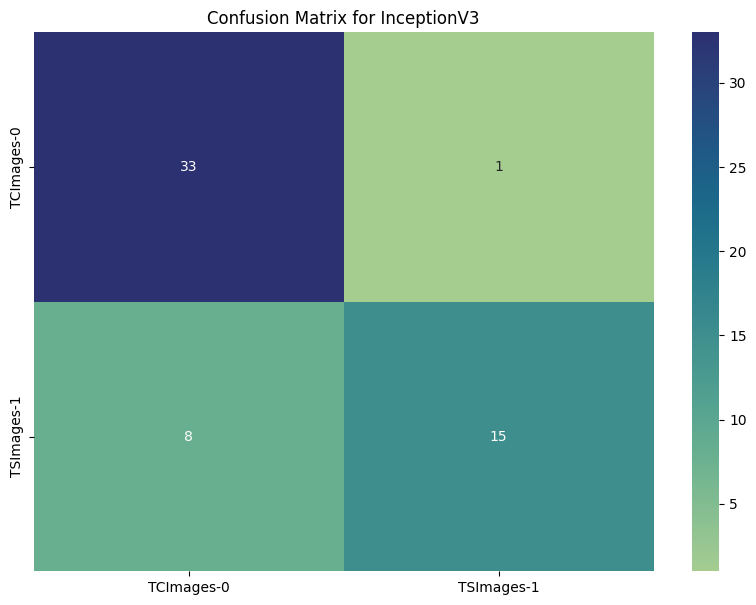

In [11]:
model_name = "InceptionV3"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)

# ResNet50 

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.5500 - loss: 1.0100 - val_accuracy: 0.4906 - val_loss: 1.2013
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8831 - loss: 0.2637 - val_accuracy: 0.4528 - val_loss: 1.1739
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9845 - loss: 0.0839 - val_accuracy: 0.5283 - val_loss: 0.8520
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9937 - loss: 0.0448 - val_accuracy: 0.5472 - val_loss: 0.8008
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9968 - loss: 0.0168 - val_accuracy: 0.5472 - val_loss: 0.8900
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.5849 - val_loss: 0.9741
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.6226 - val_loss: 1.0528
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - 

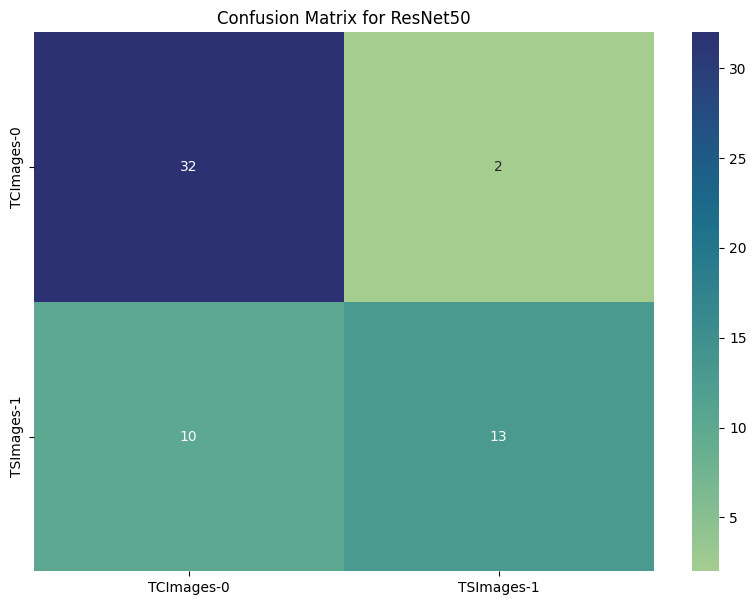

In [12]:
model_name = "ResNet50"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)

# EfficientNetB4

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 358s 12s/step - accuracy: 0.5992 - loss: 1.0097 - val_accuracy: 0.6226 - val_loss: 1.1987
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.7914 - loss: 0.5885 - val_accuracy: 0.6604 - val_loss: 1.0034
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8587 - loss: 0.3069 - val_accuracy: 0.5849 - val_loss: 1.0958
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.8869 - loss: 0.2539 - val_accuracy: 0.6038 - val_loss: 1.2327
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9114 - loss: 0.2254 - val_accuracy: 0.6415 - val_loss: 1.4330
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.9363 - loss: 0.1921 - val_accuracy: 0.6415 - val_loss: 1.4452
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.9421 - loss: 0.1881 - val_accuracy: 0.5849 - val_loss: 1.6018
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step -

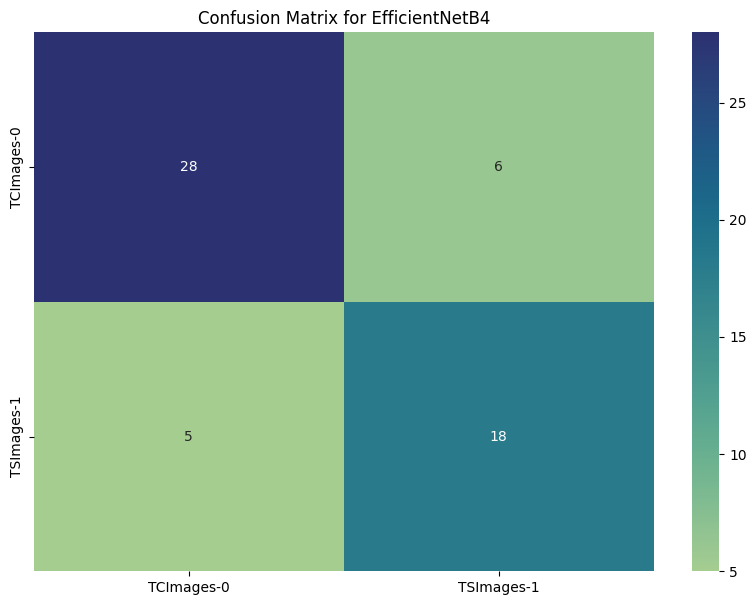

In [13]:
model_name = "EfficientNetB4"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)

# VGG19

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60


2024-06-16 10:52:15.499311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-06-16 10:52:15.499373: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-06-16 10:52:15.499388: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-06-16 10:52:15.499402: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-06-16 10:52:15.499412: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-06-16 10:52:15.499423: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-06-16 10:52:15.499434: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-06-16 10:52:15.499446: E external/local_xla/xla/se

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6172 - loss: 0.7930

2024-06-16 10:52:55.644826: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.78283, expected 2.94933
2024-06-16 10:52:55.644888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.74976, expected 4.91626
2024-06-16 10:52:55.644898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.76648, expected 4.93298
2024-06-16 10:52:55.644905: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.49029, expected 4.65679
2024-06-16 10:52:55.644913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.99986, expected 4.16636
2024-06-16 10:52:55.644923: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.68302, expected 4.84952
2024-06-16 10:52:55.644931: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.36663, expected 5.53313
2024-06-16 10:52:55.644938: E external/local_xla/xla/se

14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.6212 - loss: 0.7881 - val_accuracy: 1.0000 - val_loss: 0.2886
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.7141 - loss: 0.6002 - val_accuracy: 1.0000 - val_loss: 0.2519
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.6748 - loss: 0.5868 - val_accuracy: 1.0000 - val_loss: 0.1537
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.7329 - loss: 0.5566 - val_accuracy: 1.0000 - val_loss: 0.1833
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.7650 - loss: 0.5266 - val_accuracy: 1.0000 - val_loss: 0.2107
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.7695 - loss: 0.4842 - val_accuracy: 0.9434 - val_loss: 0.2433
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.7471 - loss: 0.5264 - val_accuracy: 0.8868 - val_loss: 0.7923
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.7815 - loss: 0.4905 - val_accuracy: 1.0000 - val_lo

2024-06-16 10:56:48.519165: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.73026, expected 4.13229
2024-06-16 10:56:48.519245: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.80661, expected 4.20864
2024-06-16 10:56:48.519265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.63226, expected 4.03429
2024-06-16 10:56:48.519279: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.7562, expected 4.15823
2024-06-16 10:56:48.519290: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.11634, expected 3.51837
2024-06-16 10:56:48.519300: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.12891, expected 2.53093
2024-06-16 10:56:48.519310: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.18796, expected 3.58999
2024-06-16 10:56:48.519321: E external/local_xla/xla

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.7310 - loss: 0.8409
Test Accuracy for VGG19: 0.5964912176132202
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 727ms/step
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        34
           1       0.00      0.00      0.00        23

   micro avg       0.60      0.60      0.60        57
   macro avg       0.30      0.50      0.37        57
weighted avg       0.36      0.60      0.45        57
 samples avg       0.60      0.60      0.60        57



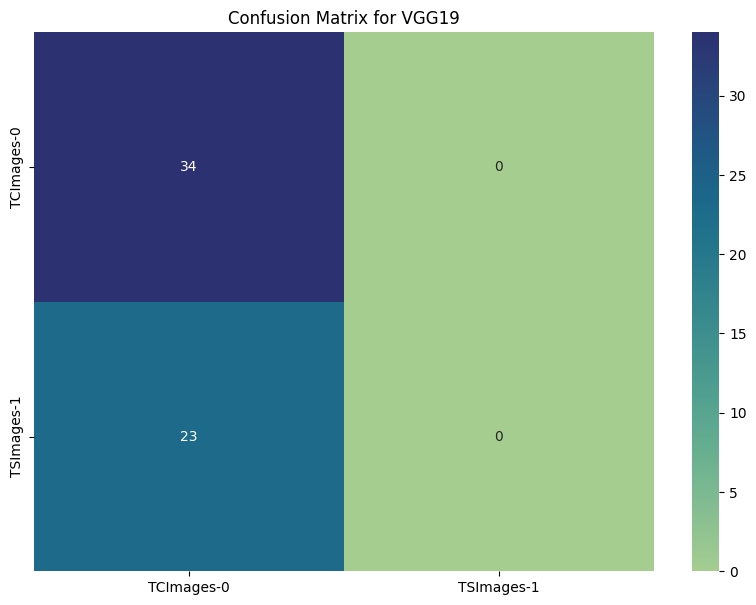

In [14]:
model_name = "VGG19"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)

# Xception

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.6140 - loss: 0.7771 - val_accuracy: 0.3962 - val_loss: 1.0832
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.8982 - loss: 0.2383 - val_accuracy: 0.5283 - val_loss: 0.9229
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.9541 - loss: 0.1295 - val_accuracy: 0.6792 - val_loss: 0.8568
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9743 - loss: 0.0823 - val_accuracy: 0.6226 - val_loss: 0.8445
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.9699 - loss: 0.0866 - val_accuracy: 0.6226 - val_loss: 0.8565
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.9859 - loss: 0.0331 - val_accuracy: 0.6981 - val_loss: 0.7596
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9877 - loss: 0.0462 - val_accuracy: 0.6604 - val_loss: 0.7290
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - 

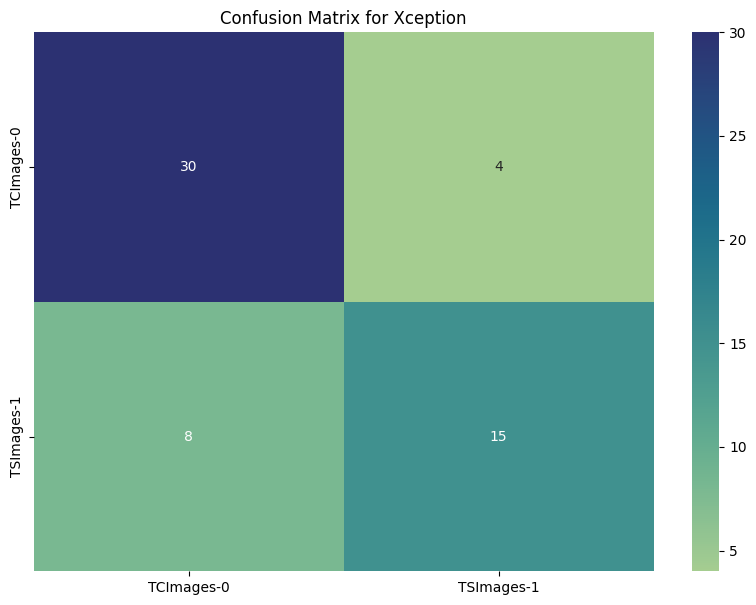

In [15]:
model_name = "Xception"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)

# NASNetMobile

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 438s 14s/step - accuracy: 0.5189 - loss: 1.1072 - val_accuracy: 0.3962 - val_loss: 2.7026
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.8376 - loss: 0.3651 - val_accuracy: 0.4151 - val_loss: 1.5636
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.8989 - loss: 0.2851 - val_accuracy: 0.4906 - val_loss: 1.1425
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.9571 - loss: 0.1346 - val_accuracy: 0.5472 - val_loss: 0.9163
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.9655 - loss: 0.1076 - val_accuracy: 0.4906 - val_loss: 0.8754
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.9971 - loss: 0.0473 - val_accuracy: 0.6038 - val_loss: 0.7774
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.9950 - loss: 0.0581 - val_accuracy: 0.5849 - val_loss: 0.7452
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step -

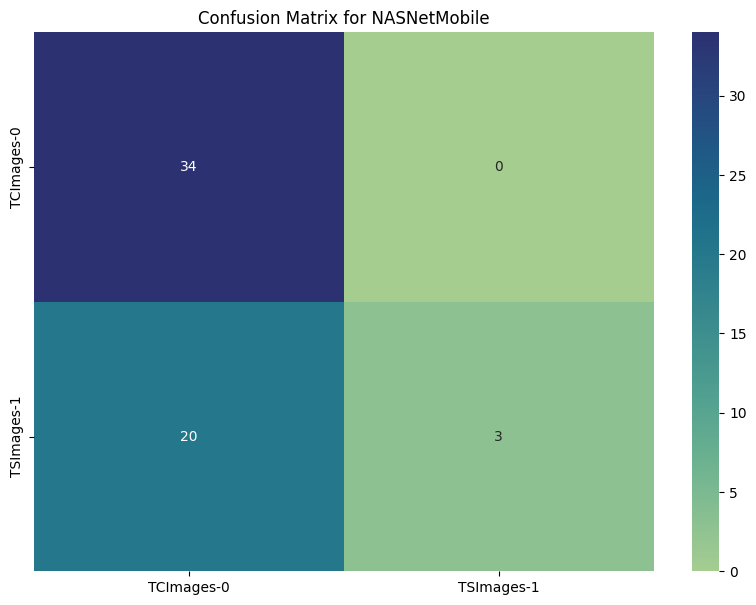

In [16]:
model_name = "NASNetMobile"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)